In [25]:
import csv
import random
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

# Tests to see if Burke model structural changes can improve prediction intervals

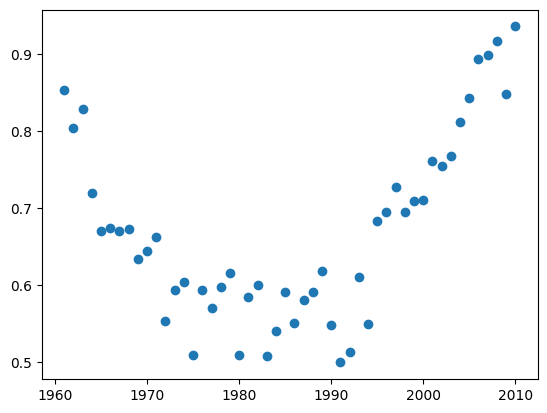

In [131]:
# Are prediction intervals off based on country/continent/year? (check via Delta method)
random.seed(1)

all_countries = list(set(data.iso))
all_years = list(set(data.year))

scores_by_continent = {}
scores_by_country = {}
scores_by_random_country = {}
scores_by_year = {}
scores_by_random_year = {}

# delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_insample.csv")
delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_third_degree_grad_effects_insample.csv")

for row in delta_yhat.itertuples():
    continent = row.continent
    country = row.iso
    year = row.year
    random_country = random.choice(all_countries)
    random_year = random.choice(all_years)
    if continent not in scores_by_continent:
        scores_by_continent[continent] = {"in_range":0,"out_range":0}
    if country not in scores_by_country:
        scores_by_country[country] = {"in_range":0,"out_range":0}
    if random_country not in scores_by_random_country:
        scores_by_random_country[random_country] = {"in_range":0,"out_range":0}
    if year not in scores_by_year:
        scores_by_year[year] = {"in_range":0,"out_range":0}
    if random_year not in scores_by_random_year:
        scores_by_random_year[random_year] = {"in_range":0,"out_range":0}
    lower = row.lower
    upper = row.upper
    real_y.append(row.growthwdi)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        scores_by_continent[continent]["in_range"] += 1
        scores_by_country[country]["in_range"] += 1
        scores_by_random_country[random_country]["in_range"] += 1
        scores_by_year[year]["in_range"] += 1
        scores_by_random_year[random_year]["in_range"] += 1
    else:
        scores_by_continent[continent]["out_range"] += 1
        scores_by_country[country]["out_range"] += 1
        scores_by_random_country[random_country]["out_range"] += 1
        scores_by_year[year]["out_range"] += 1
        scores_by_random_year[random_year]["out_range"] += 1

# for continent, scores in scores_by_continent.items():
#     print(continent)
#     print(scores)
#     print(scores["in_range"] / (scores["in_range"] + scores["out_range"]))
#     print(scores["out_range"] / (scores["in_range"] + scores["out_range"]))
all_country_in_range_scores = {}
random_country_in_range_scores = {}
year_in_range_scores = {}
random_year_in_range_scores = {}
for country, scores in scores_by_country.items():
    # print(country)
    # print(scores)
    # print(scores["in_range"] / (scores["in_range"] + scores["out_range"]))
    # print(scores["out_range"] / (scores["in_range"] + scores["out_range"]))
    all_country_in_range_scores[country] = (scores["in_range"] / (scores["in_range"] + scores["out_range"]))
for country, scores in scores_by_random_country.items():
    random_country_in_range_scores[country] = (scores["in_range"] / (scores["in_range"] + scores["out_range"]))
for year, scores in scores_by_year.items():
    year_in_range_scores[year] = (scores["in_range"] / (scores["in_range"] + scores["out_range"]))
for year, scores in scores_by_random_year.items():
    random_year_in_range_scores[year] = (scores["in_range"] / (scores["in_range"] + scores["out_range"]))

# Check to see if variation in country scores is greater than random chance
# print(np.mean(list(all_country_in_range_scores.values())), np.std(list(all_country_in_range_scores.values())))
# print(np.mean(list(random_country_in_range_scores.values())), np.std(list(random_country_in_range_scores.values())))

# Which countries are performing the worst?
countries_worst_to_best = [k for k, v in sorted(all_country_in_range_scores.items(), key=lambda item: item[1])]

# Is there more variation in the target variable or covariates in these countries?
best_ten_countries = countries_worst_to_best[-10:]
worst_ten_countries = countries_worst_to_best[:10]

best_countries_data = {country:{"temps":[],"precips":[],"gdps":[]} for country in best_ten_countries}
worst_countries_data = {country:{"temps":[],"precips":[],"gdps":[]} for country in worst_ten_countries}

for row in data.itertuples():
    if row.iso in best_ten_countries:
        best_countries_data[row.iso]["temps"].append(row.UDel_temp_popweight)
        best_countries_data[row.iso]["precips"].append(row.UDel_precip_popweight)
        best_countries_data[row.iso]["gdps"].append(row.growthWDI)
    elif row.iso in worst_ten_countries:
        worst_countries_data[row.iso]["temps"].append(row.UDel_temp_popweight)
        worst_countries_data[row.iso]["precips"].append(row.UDel_precip_popweight)
        worst_countries_data[row.iso]["gdps"].append(row.growthWDI)

best_country_temp_std = np.mean([np.std(best_countries_data[country]["temps"]) for country in best_countries_data])
worst_country_temp_std = np.mean([np.std(worst_countries_data[country]["temps"]) for country in worst_countries_data])
# print(best_country_temp_std, worst_country_temp_std)

best_country_precip_std = np.mean([np.std(best_countries_data[country]["precips"]) for country in best_countries_data])
worst_country_precip_std = np.mean([np.std(worst_countries_data[country]["precips"]) for country in worst_countries_data])
# print(best_country_precip_std, worst_country_precip_std)

best_country_gdp_std = np.mean([np.std(best_countries_data[country]["gdps"]) for country in best_countries_data])
worst_country_gdp_std = np.mean([np.std(worst_countries_data[country]["gdps"]) for country in worst_countries_data])
# print(best_country_gdp_std, worst_country_gdp_std)

# Check to see if variation in year scores is greater than random chance
# print(np.mean(list(year_in_range_scores.values())), np.std(list(year_in_range_scores.values())))
# print(np.mean(list(random_year_in_range_scores.values())), np.std(list(random_year_in_range_scores.values())))

# Which years are performing the worst?
years_worst_to_best = {k: v for k, v in sorted(year_in_range_scores.items(), key=lambda item: item[1])}
# print(years_worst_to_best)

plt.scatter(list(years_worst_to_best.keys()), list(years_worst_to_best.values()))

# Is there more variation in the target variable or covariates in these years?
years_worst_to_best = list(years_worst_to_best.keys())
best_ten_years = years_worst_to_best[-10:]
worst_ten_years = years_worst_to_best[:10]

best_years_data = {year:{"temps":[],"precips":[],"gdps":[]} for year in best_ten_years}
worst_years_data = {year:{"temps":[],"precips":[],"gdps":[]} for year in worst_ten_years}

for row in data.itertuples():
    if row.year in best_ten_years:
        best_years_data[row.year]["temps"].append(row.UDel_temp_popweight)
        best_years_data[row.year]["precips"].append(row.UDel_precip_popweight)
        best_years_data[row.year]["gdps"].append(row.growthWDI)
    elif row.year in worst_ten_years:
        worst_years_data[row.year]["temps"].append(row.UDel_temp_popweight)
        worst_years_data[row.year]["precips"].append(row.UDel_precip_popweight)
        worst_years_data[row.year]["gdps"].append(row.growthWDI)

best_year_temp_std = np.mean([np.std(best_years_data[year]["temps"]) for year in best_years_data])
worst_year_temp_std = np.mean([np.std(worst_years_data[year]["temps"]) for year in worst_years_data])
# print(best_year_temp_std, worst_year_temp_std)

best_year_precip_std = np.mean([np.std(best_years_data[year]["precips"]) for year in best_years_data])
worst_year_precip_std = np.mean([np.std(worst_years_data[year]["precips"]) for year in worst_years_data])
# print(best_year_precip_std, worst_year_precip_std)

best_year_gdp_std = np.mean([np.std(best_years_data[year]["gdps"]) for year in best_years_data])
worst_year_gdp_std = np.mean([np.std(worst_years_data[year]["gdps"]) for year in worst_years_data])
# print(best_year_gdp_std, worst_year_gdp_std)

# plot the relationship of the target variable and year for 10 countries
# plt.scatter(list(data.loc[(data["iso"]=="USA")]["year"]), list(data.loc[(data["iso"]=="USA")]["growthWDI"]))
# plt.scatter(list(data.loc[(data["iso"]=="FRA")]["year"]), list(data.loc[(data["iso"]=="FRA")]["growthWDI"]))
# plt.scatter(list(data.loc[(data["iso"]=="CHN")]["year"]), list(data.loc[(data["iso"]=="CHN")]["growthWDI"]))

# Ortiz-Bobea data

In [10]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
test_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_test.csv")
train_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_train.csv")
ordered_country_list = list(dict.fromkeys(train_data.ISO3))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]

/tmp/ipykernel_6514/3786652120.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]


# Make dataset withholding random points

In [108]:
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [11]:
data_mod.to_csv("../data/ortiz-bobea/data2/regdata_train.csv")

In [12]:
pd.DataFrame(withheld_rows).to_csv("../data/ortiz-bobea/data2/regdata_test.csv")

In [ ]:
pd.DataFrame(data).to_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")

# Delta method

In [21]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
real_y = []

delta_yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_outsample.csv")
# yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_insample.csv")
for row in enumerate(delta_yhat.itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    real_y.append(row[1].fd_log_tfp)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

0.38271604938271603
0.6172839506172839


# Bootstrap model from Stata

In [19]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld_better_column_names.csv")

In [23]:
# bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld_better_column_names.csv", header=1)
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_block_withheld_better_column_names.csv", header=1)
missing_indices = []
for index, row in enumerate(bootstrap_reps.itertuples()):
    if np.isnan(row.fd_tmean):
        missing_indices.append(index)
bootstrap_reps = bootstrap_reps.drop(missing_indices).reset_index(drop=True)[:1000]

boot_yhat = []
real_y = []
# for row in test_data.iterrows():
for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    predict_tfp = (
        temp*bootstrap_reps["fd_tmean"] + 
        temp2*bootstrap_reps["fd_tmean_sq"] +
        precip*bootstrap_reps["fd_prcp"] +
        precip2*bootstrap_reps["fd_prcp_sq"] +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    boot_yhat.append(sorted(predict_tfp))

In [24]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

0.36670025752995183
0.6332997424700482


/tmp/ipykernel_6514/3369681978.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ortiz_fig.show()


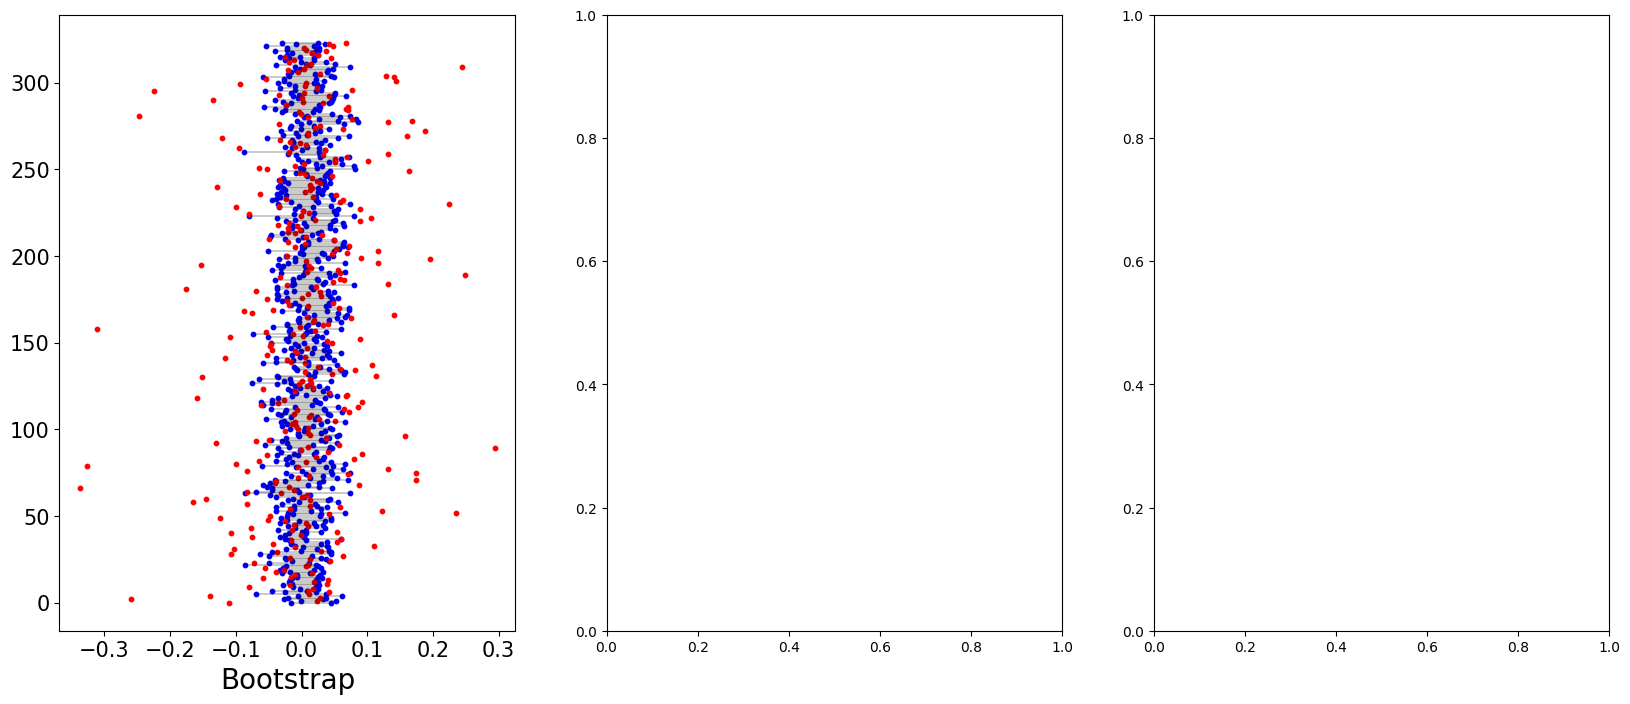

In [22]:
ortiz_fig, (ortiz_ax1, ortiz_ax2, ortiz_ax3) = plt.subplots(1,3, figsize=(20,8))

ortiz_ax1.scatter(boot_lowers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(boot_uppers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(real_y, list(range(len(boot_yhat))), color="red", s=10)
for index in range(len(boot_yhat)):
    ortiz_ax1.plot([boot_lowers[index],boot_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax1.set_xlabel("Bootstrap")
ortiz_ax1.xaxis.label.set_size(20)
ortiz_ax1.xaxis.set_tick_params(labelsize=15)
ortiz_ax1.yaxis.set_tick_params(labelsize=15)

ortiz_fig.show()

# Bayesian model

In [24]:
model = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')
trace = model["trace"]

In [25]:
bayes_coef1 = trace.posterior.fd_temp_tfp_coef.data.flatten()
bayes_coef2 = trace.posterior.fd_sq_temp_tfp_coef.data.flatten()
bayes_coef3 = trace.posterior.fd_precip_tfp_coef.data.flatten()
bayes_coef4 = trace.posterior.fd_sq_precip_tfp_coef.data.flatten()
intercept = trace.posterior.tfp_intercept.data.flatten()
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [26]:
bayes_yhat = []
real_y = []
min_year = min(train_data.year)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_tfp = (
        temp*bayes_coef1 + 
        temp2*bayes_coef2 +
        precip*bayes_coef3 +
        precip2*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    bayes_yhat.append(sorted(predict_tfp))

In [27]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

0.38580246913580246
0.6141975308641975


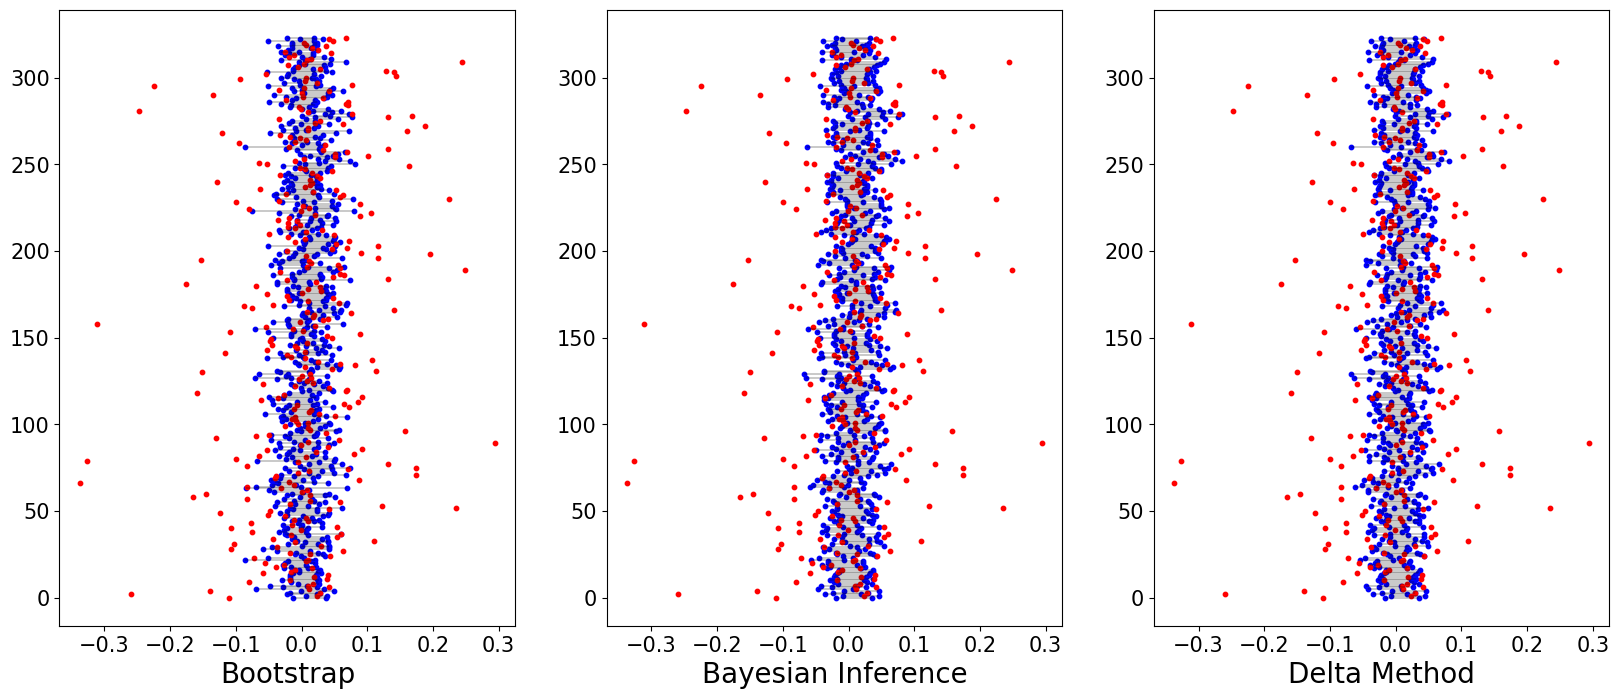

In [28]:
ortiz_fig, (ortiz_ax1, ortiz_ax2, ortiz_ax3) = plt.subplots(1,3, figsize=(20,8))

ortiz_ax1.scatter(boot_lowers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(boot_uppers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(real_y, list(range(len(boot_yhat))), color="red", s=10)
for index in range(len(boot_yhat)):
    ortiz_ax1.plot([boot_lowers[index],boot_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax1.set_xlabel("Bootstrap")
ortiz_ax1.xaxis.label.set_size(20)
ortiz_ax1.xaxis.set_tick_params(labelsize=15)
ortiz_ax1.yaxis.set_tick_params(labelsize=15)

ortiz_ax2.scatter(bayes_lowers, list(range(len(bayes_yhat))), color="blue", s=10)
ortiz_ax2.scatter(bayes_uppers, list(range(len(bayes_yhat))), color="blue", s=10)
ortiz_ax2.scatter(real_y, list(range(len(bayes_yhat))), color="red", s=10)
for index in range(len(bayes_yhat)):
    ortiz_ax2.plot([bayes_lowers[index],bayes_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax2.set_xlabel("Bayesian Inference")
ortiz_ax2.xaxis.label.set_size(20)
ortiz_ax2.xaxis.set_tick_params(labelsize=15)
ortiz_ax2.yaxis.set_tick_params(labelsize=15)

ortiz_ax3.scatter(delta_lowers, list(range(len(delta_yhat))), color="blue", s=10)
ortiz_ax3.scatter(delta_uppers, list(range(len(delta_yhat))), color="blue", s=10)
ortiz_ax3.scatter(real_y, list(range(len(delta_yhat))), color="red", s=10)
for index in range(len(delta_yhat)):
    ortiz_ax3.plot([delta_lowers[index],delta_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax3.set_xlabel("Delta Method")
ortiz_ax3.xaxis.label.set_size(20)
ortiz_ax3.xaxis.set_tick_params(labelsize=15)
ortiz_ax3.yaxis.set_tick_params(labelsize=15)
    
ortiz_fig.savefig("../figures/ortiz_prediction_intervals.png", bbox_inches='tight')